In [119]:
import pandas as pd
import numpy as np


In [120]:
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/projects/F1 Championship Model/data/final_model_data.csv")


In [121]:
results['grid'] = pd.to_numeric(results['grid'], errors='coerce')


In [122]:
results = results.sort_values(by=['driver_id','race_id'])

results['rolling_avg_finish'] = (
    results.groupby('driver_id')['position_order']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)


In [123]:
features = [
    'recent_DCI',
    'constructor_strength',
    'championship_score'
]

X = df[features]
y = (df['championship_score'] > df['championship_score'].median()).astype(int)



In [124]:
X = X.fillna(X.median())

In [125]:
import sys
sys.executable

'c:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python314\\python.exe'

In [126]:
from xgboost import XGBClassifier


In [127]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=300,
    max_depth =6,
    learning_rate=0.05,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]

print("ROC_AUC:", roc_auc_score(y_test, y_pred_proba))


ROC_AUC: 1.0


In [129]:
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


ROC-AUC: 1.0


In [130]:
print(X.columns.tolist())


['recent_DCI', 'constructor_strength', 'championship_score']


In [131]:
from sklearn.metrics import average_precision_score
print(average_precision_score(y_test, y_pred_proba))


1.0


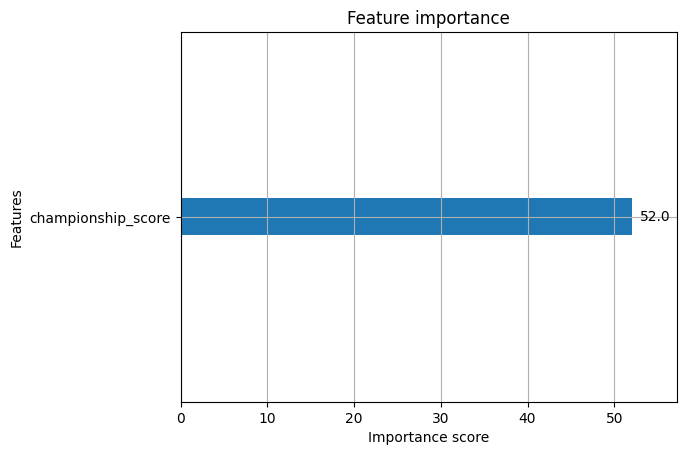

In [132]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()


In [133]:
from sklearn.calibration import CalibratedClassifierCV

cal_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
cal_model.fit(X_train, y_train)

y_cal = cal_model.predict_proba(X_test)[:,1]
print("PR-AUC:", average_precision_score(y_test, y_cal))


PR-AUC: 1.0


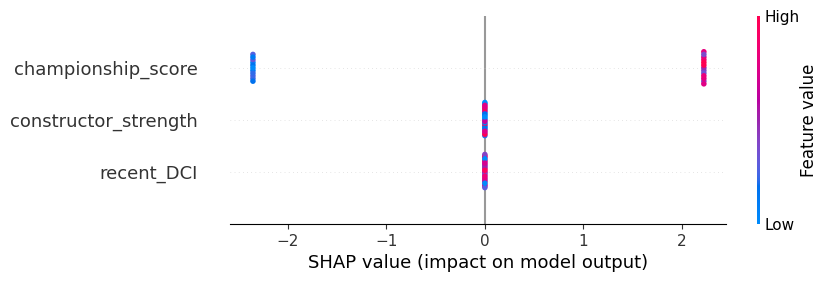

In [134]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)


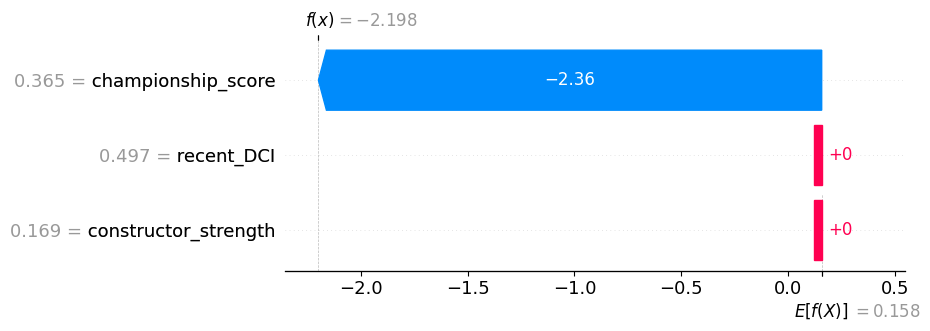

In [135]:
race_data = X_test.iloc[0:10]   # or one race subset

shap_values = explainer(race_data)

shap.plots.waterfall(shap_values[0])


In [136]:
import pandas as pd

shap_df = pd.DataFrame(
    shap_values.values,
    columns=X.columns
)

print(shap_df.iloc[0].sort_values(ascending=False))


recent_DCI              0.000000
constructor_strength    0.000000
championship_score     -2.355906
Name: 0, dtype: float32


In [137]:
import joblib

joblib.dump(model, "model.pkl")


['model.pkl']

In [138]:
model = joblib.load("model.pkl")


In [144]:
import streamlit as st
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

st.title("🏎️ F1 Win Probability Predictor")

# --- load your trained model ---
model = joblib.load("model.pkl")

# sample race data (replace with your real data loader)
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/projects/F1 Championship Model/data/final_model_data.csv")

FEATURES = [
    'recent_DCI',
    'constructor_strength',
    'championship_score'
]

X = df[FEATURES]

probs = model.predict_proba(X)[:, 1]


results = df.copy()
results["win_prob"] = probs

# show table
st.subheader("Win Probabilities")
st.dataframe(results.sort_values("win_prob", ascending=False))

# bar chart
st.bar_chart(results.set_index("driver_id")["win_prob"])


# --- SHAP explanation ---
st.subheader("🔍 Why this prediction? (SHAP)")

explainer = shap.TreeExplainer(model)

shap_values = explainer(X)

import matplotlib.pyplot as plt

plt.figure()                     # create figure FIRST
shap.plots.waterfall(
    shap_values[0],
    show=False
)

st.pyplot(plt.gcf())             # send current figure
plt.close()




2026-02-12 18:13:23.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.988 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.991 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-12 18:13:23.997 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [145]:
print(model.feature_names_in_)


['recent_DCI' 'constructor_strength' 'championship_score']


In [146]:
features = model.feature_names_in_

X_shap = results[features]


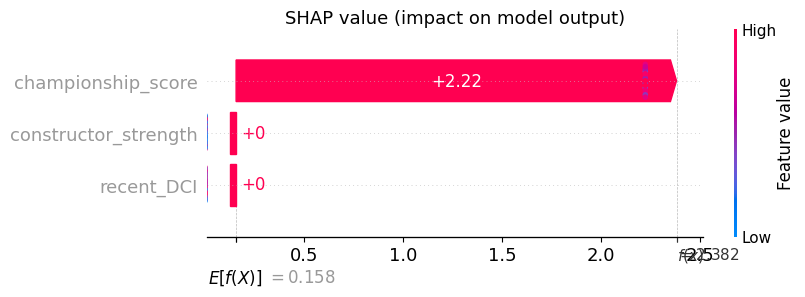

In [147]:
import shap

explainer = shap.Explainer(model)

sample = X_shap.iloc[:200]  # small for speed
shap_values = explainer(sample)

shap.plots.beeswarm(shap_values)


In [148]:
joblib.dump(model, "model.pkl")


['model.pkl']